In [0]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

In [0]:
! unzip Cat_Dog_data.zip

In [0]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

In [0]:
data_dir = "Cat_Dog_data"

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_dir+'/train', transform = train_transforms)
test_dataset = datasets.ImageFolder(data_dir+'/test', transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg19_bn(pretrained=True)

for params in model.parameters():
    params.require_grad = False
    

model.classifier = nn.Sequential(OrderedDict([
                                              ('fc1', nn.Linear(25088,4096)),
                                              ('relu', nn.ReLU()),
                                              ('dropout', nn.Dropout(0.2)),
                                              ('fc2', nn.Linear(4096,256)),
                                              ('relu', nn.ReLU()),
                                              ('dropout', nn.Dropout(0.2)),
                                              ('fc3', nn.Linear(256, 2)),
                                              ('output', nn.LogSoftmax(dim=1))]))

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.02)

In [84]:
epochs = 1
steps = 0
print_every = 5
train_losses, val_losses = [], []

for epoch in range(epochs):
  
  train_loss =0
  for images, labels in train_loader:
    
    steps+=1
    
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    log_ps = model.forward(images)
    loss = criterion(log_ps, labels) 
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
    
    if (steps%print_every == 0):
      test_loss =0
      accuracy=0
      model.eval()
      with torch.no_grad():
        for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          log_ps = model.forward(images)
          loss = criterion(log_ps, labels)
          test_loss += loss.item()
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
      print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
      train_loss = 0
      model.train()

Epoch 1/1.. Train loss: 1971.207.. Test loss: 90.377.. Test accuracy: 0.640
Epoch 1/1.. Train loss: 79.435.. Test loss: 9.232.. Test accuracy: 0.922
Epoch 1/1.. Train loss: 20.826.. Test loss: 0.808.. Test accuracy: 0.968
Epoch 1/1.. Train loss: 4.301.. Test loss: 1.014.. Test accuracy: 0.930
Epoch 1/1.. Train loss: 4.979.. Test loss: 3.258.. Test accuracy: 0.946
Epoch 1/1.. Train loss: 6.915.. Test loss: 3.244.. Test accuracy: 0.945
Epoch 1/1.. Train loss: 4.307.. Test loss: 2.133.. Test accuracy: 0.952
Epoch 1/1.. Train loss: 3.074.. Test loss: 0.751.. Test accuracy: 0.957
Epoch 1/1.. Train loss: 1.615.. Test loss: 0.493.. Test accuracy: 0.963
Epoch 1/1.. Train loss: 0.765.. Test loss: 0.363.. Test accuracy: 0.954
Epoch 1/1.. Train loss: 0.623.. Test loss: 0.136.. Test accuracy: 0.971
Epoch 1/1.. Train loss: 0.434.. Test loss: 0.188.. Test accuracy: 0.966
Epoch 1/1.. Train loss: 0.496.. Test loss: 0.093.. Test accuracy: 0.975
Epoch 1/1.. Train loss: 0.280.. Test loss: 0.156.. Test ac

In [0]:
torch.save(model.state_dict(), 'checkpoint_vgg19.pth')

In [87]:
state_dict = torch.load('checkpoint_vgg19.pth')
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.0629, 0.9371]])


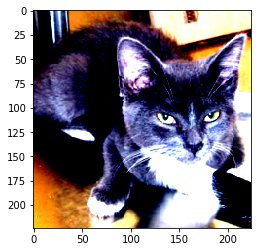

In [94]:
%matplotlib inline

with torch.no_grad():
  model.to('cpu')
  images, labels = next(iter(test_loader))
  images = images.to('cpu')
  img = images[4].view(1,3,224,224)
  logps = model.forward(img)
  ps = torch.exp(logps)
  plt.imshow(img.view(3,224,224).permute(1,2,0))
  print(ps)